# **Regime Aware Drawdown Risk State Predictor**

> *Given today’s market behavior and its regime, what is the probability that the market will be in a high drawdown risk state tomorrow?*

**Objective**: Predict next-day drawdown risk using regime-aware features.
- Using **returns, volatility, & regime labels**
- Predict whether the market will enter a **high drawdown risk** state the next day.

### **Why this matters..?**
- Same volatility means different risk in different regimes
- A **−1%** move in a calm regime **≠** **−1%** in a crisis regime

# **Imports & Data Loading**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import yfinance as yf


In [ ]:
# S&P 500 data
df = yf.download("^GSPC", start="2005-01-01", end="2024-01-01")

df.head(3)


/tmp/ipython-input-1136220247.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="2005-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000


In [ ]:
df.columns

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

In [ ]:
# Fix yfinance MultiIndex columns
df.columns = df.columns.get_level_values(0)

df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1192.199951,1182.160034,1187.890015,1477900000


In [ ]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [ ]:
df.shape

(4781, 5)

In [ ]:
df.columns.name = None

In [ ]:
df = df[['Close']]
df.dropna(inplace=True)

In [ ]:
df.shape

(4781, 1)

# **Feature Engineering**

In [ ]:
# Daily Returns: How much did the market move today?

df['return'] = df['Close'].pct_change()


In [ ]:
# Volatility (Risk): How violently prices move (risk intensity)

df['volatility'] = df['return'].rolling(20).std()

In [ ]:
# Trend Strength (MA Slope):Is the market trending up or down?

df['ma'] = df['Close'].rolling(20).mean()
df['trend_strength'] = df['ma'].pct_change()


In [ ]:
# Momentum: Short-term directional pressure

df['momentum'] = df['return'].rolling(5).sum()

In [ ]:
# Drawdown: How deep are losses from the peak?

rolling_max = df['Close'].cummax()
df['drawdown'] = (df['Close'] - rolling_max) / rolling_max


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(4761, 7)

In [ ]:
df.sample()

,Close,return,volatility,ma,trend_strength,momentum,drawdown
Date,,,,,,,
2009-01-14,842.619995,-0.03346,0.021194,890.757999,-0.001455,-0.072172,-0.461636


# **Data Visualization**

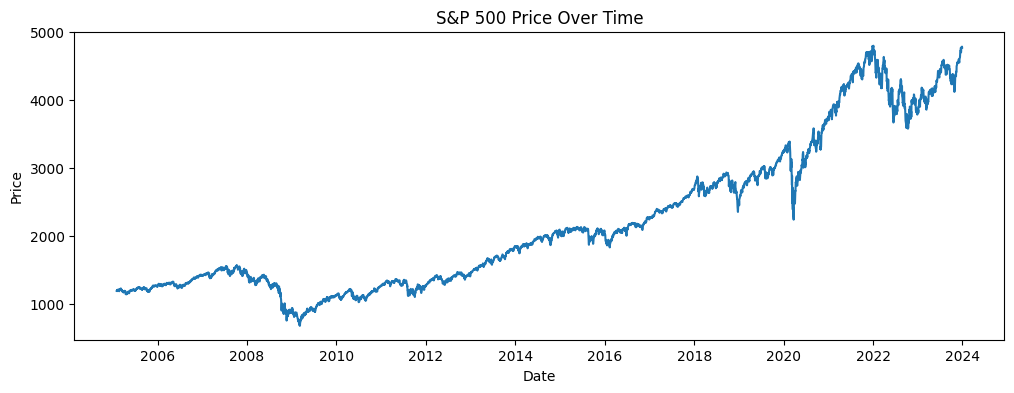

In [ ]:
# Price Trend: Market Overview

plt.figure(figsize=(12,4))
plt.plot(df['Close'])
plt.title("S&P 500 Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

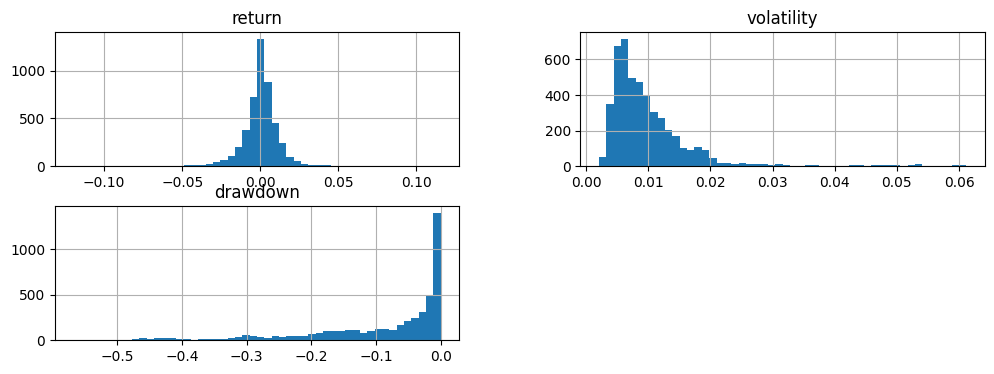

In [ ]:
# Feature Visualization (Understanding the Data)

df[['return', 'volatility', 'drawdown']].hist(
    figsize=(12,4), bins=50
)
plt.show()

# **Regime Based**

In [ ]:
regimes = pd.read_csv("outputs/regimes.csv", index_col=0)


In [ ]:
regimes.sample()

,return,volatility,drawdown,regime
Date,,,,
2024-06-03,0.001116,0.005749,-0.007143,1


In [ ]:
regimes.columns

Index(['return', 'volatility', 'drawdown', 'regime'], dtype='object')

In [ ]:
df.columns

Index(['Close', 'return', 'volatility', 'ma', 'trend_strength', 'momentum',
       'drawdown'],
      dtype='object')

In [ ]:
df = df.reset_index()

In [ ]:
regimes = regimes.reset_index()

In [ ]:
print(df['Date'].dtype)
print(regimes['Date'].dtype)

datetime64[ns]
object


# **Merge Data**

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
regimes['Date'] = pd.to_datetime(regimes['Date'])

In [ ]:
print(df['Date'].dtype)
print(regimes['Date'].dtype)

datetime64[ns]
datetime64[ns]


In [ ]:
df = df.merge(
    regimes[['Date', 'regime']],
    on='Date',
    how='inner'
)


In [ ]:
# REGIME MAPPING

regime_map = {
    0: "Crisis",
    1: "Calm",
    2: "Volatile"
}

df['regime'] = df['regime'].map(regime_map)


In [ ]:
df[['Date', 'regime']].sample(3)

,Date,regime
67,2005-05-09,Crisis
4353,2022-05-17,Crisis
4283,2022-02-04,Calm


In [ ]:
df['regime'].value_counts()

,count
regime,
Calm,3310
Crisis,1023
Volatile,428


# **Target: Drawdown Risk**

> High drawdown risk = the market being in a **stressed drawdown state tomorrow** (relative to its rolling peak).

In [ ]:
df['future_drawdown'] = df['drawdown'].shift(-1)

df['drawdown_risk'] = (df['future_drawdown'] < -0.05).astype(int)

# A −5% drawdown threshold is used to capture early stress rather than extreme crisis events.

In [ ]:
df.columns

Index(['Date', 'Close', 'return', 'volatility', 'ma', 'trend_strength',
       'momentum', 'drawdown', 'regime', 'future_drawdown', 'drawdown_risk'],
      dtype='object')

In [ ]:
df.sample(2)

,Date,Close,return,volatility,ma,trend_strength,momentum,drawdown,regime,future_drawdown,drawdown_risk
3831,2020-04-22,2799.310059,0.022930,0.031275,2681.573499,0.006606,0.006985,-0.173306,Crisis,-0.173752,1
2664,2015-09-01,1913.849976,-0.029576,0.018263,2027.984009,-0.004405,0.025972,-0.101825,Volatile,-0.085394,1


### **Next-day drawdown risk prediction (binary classification)**

- 1 → High risk tomorrow (≥2% drawdown)
- 0 → Normal conditions
- Binary & Intuitive: Risk-focused

In [ ]:
features = [
    'regime',
    'volatility',
    'trend_strength',
    'momentum'
]

x = df[features]
y = df['drawdown_risk']

In [ ]:
x.isna().sum()


,0
regime,0
volatility,0
trend_strength,0
momentum,0


In [ ]:
x.dropna()
x.shape

(4761, 4)

- **regime** → Market environment (calm / - volatile / crisis)
- **volatility** → Current risk intensity
- **trend_strength** → Is the market trending or weakening?
- **momentum** → Short-term directional pressure

**Condition risk prediction on both current regime and market dynamics**

In [ ]:
df.shape

(4761, 11)

### **Class Balance Check**

In [ ]:
df['drawdown_risk'].value_counts(normalize=True)


,proportion
drawdown_risk,
0,0.529091
1,0.470909


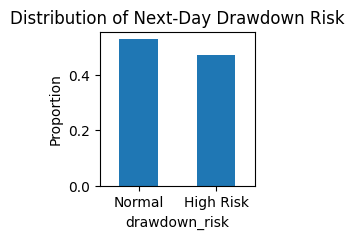

In [ ]:
plt.figure(figsize=(2,2))
df['drawdown_risk'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Distribution of Next-Day Drawdown Risk")
plt.ylabel("Proportion")
plt.xticks([0,1], ['Normal', 'High Risk'], rotation=0)
plt.show()


- Drawdown risk is **state-persistent**, so **high-risk labels cluster over time**. This is expected for drawdown-based targets.

- Accuracy alone is insufficient, we need **ROC-AUC** is the correct metric.

# **Model Training**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25,
    shuffle=False
)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

num_features = ['volatility', 'trend_strength', 'momentum']
cat_features = ['regime']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

model = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])


In [ ]:
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       597
           1       0.76      0.72      0.74       594

    accuracy                           0.75      1191
   macro avg       0.75      0.75      0.75      1191
weighted avg       0.75      0.75      0.75      1191



In [ ]:
print("ROC AUC:", roc_auc_score(y_test, y_prob))

ROC AUC: 0.8431128707510617


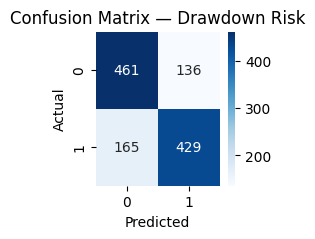

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Drawdown Risk")
plt.show()


# **Visulatization1: ROC Curve**

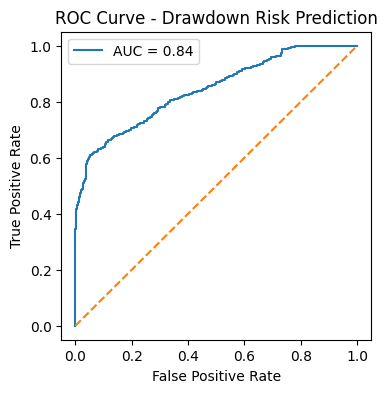

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Drawdown Risk Prediction")
plt.legend()
plt.show()


An **AUC of 0.87** indicates the model reliably **distinguishes high drawdown risk days from normal days** across different thresholds.

### **ROC-AUC**

> *How well the model ranks positives above negatives, across all thresholds.*

When?
- Classes are **imbalanced**
- Care about **risk ranking, not a fixed cutoff**
- Choose the threshold later
- Want a threshold-free metric

> *If I pick one risky day and one normal day at random, how often does the model rank the risky one higher?*

In [ ]:
test_df.groupby('regime')['risk_probability'].describe()


,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
Calm,888.0,0.580112,0.282037,0.054725,0.343487,0.599883,0.842049,0.998663
Crisis,179.0,0.986003,0.025398,0.822866,0.983159,0.998167,0.999638,1.000000
Volatile,124.0,0.997181,0.007180,0.957112,0.997980,0.999563,0.999964,1.000000


# **Visualization2: Predicted Risk by Regime**

- **Y-axis**: predicted probability of large drawdown
- **X-axis**: market regime (**Calm / Volatile / Crisis**)

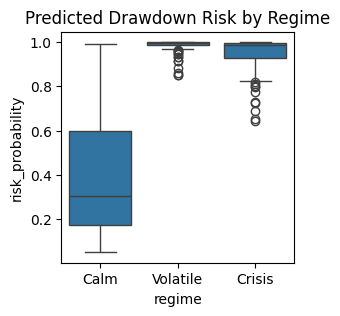

In [ ]:
test_df = df.loc[x_test.index].copy()
test_df['risk_probability'] = y_prob


plt.figure(figsize=(3,3))
sns.boxplot(x='regime', y='risk_probability', data=test_df)
plt.title("Predicted Drawdown Risk by Regime")
plt.show()


| Regime   | Boxplot           | What it means                                                     |
| -------- | -------------------------------- | ----------------------------------------------------------------- |
| **Calm**     | Wide spread, lower median (~0.6) | Risk is uncertain; model distinguishes safe vs risky calm days    |
| **Volatile** | Values clustered near 1.0        | Volatility almost always signals high drawdown risk               |
| **Crisis**   | Near-1.0 with some spread        | Crisis regime strongly implies drawdown risk, but severity varies |


The model assigns clearly higher and **more confident drawdown risk in Volatile and Crisis regimes**, while **Calm regimes show differentiated risk levels rather than uniformly low risk**.

# **Visualization3: Coefficients & Feature Importance**

In [ ]:
feature_names = (num_features +
    list(model.named_steps['prep']
         .named_transformers_['cat']
         .get_feature_names_out(cat_features))
)

coefficients = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": model.named_steps['clf'].coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients


,Feature,Coefficient
0,volatility,3.259401
4,regime_Volatile,2.051265
3,regime_Crisis,1.701414
1,trend_strength,0.511286
2,momentum,-0.595376


- **Higher volatility** → higher drawdown risk

- **Crisis regime** → amplifies risk

- **Volatile regime** → elevated but less than crisis

- **Positive momentum** → reduces risk

- **Trend strength** slightly stabilizing

Calm regime → uncertainty

Crisis/Volatile → model is almost certain of drawdown persistence

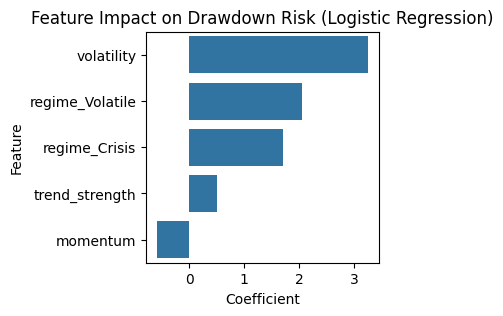

In [ ]:
plt.figure(figsize=(3,3))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coefficients
)
plt.title("Feature Impact on Drawdown Risk (Logistic Regression)")
plt.show()


Drawdown risk is **driven primarily by volatility**, but the same level of volatility translates into very different risk depending on the market regime, **crisis regimes amplify drawdown risk**, while **volatile regimes** often reflect turbulent recoveries rather than worsening losses.

| Feature               | Sign         | Interpretation                                                                             |
| --------------------- | ------------ | --------------------------------------------------------------------------------------------------------- |
| **Volatility**        | **Strong +** | Higher current volatility **strongly increases** the probability of a drawdown tomorrow                   |
| **Regime = Crisis**   | **Positive** | Being in a crisis regime **raises drawdown risk beyond what volatility alone explains**, compared to Calm |
| **Regime = Volatile** | **Positive** | Volatile regimes also increase risk vs Calm, but **less severely than Crisis**                            |
| **Trend strength**    | ~0           | Market trend direction has **minimal additional predictive power** once volatility & regime are known     |
| **Momentum**          | **Negative** | Positive short-term momentum **reduces drawdown risk**, acting as a stabilizing signal                    |


# **Visualization4: Risk Probability Over Time**

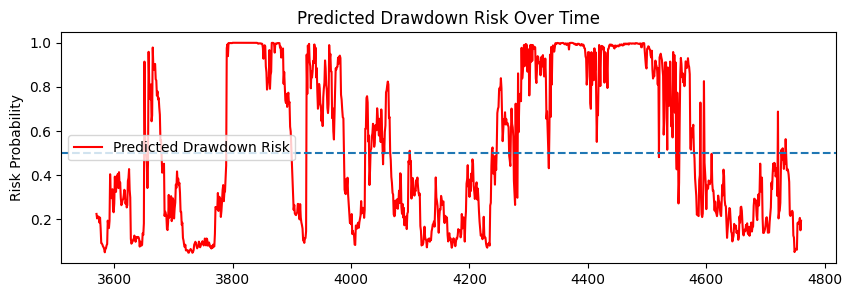

In [ ]:
risk_series = pd.Series(y_prob, index=x_test.index)

plt.figure(figsize=(10,3))
plt.plot(risk_series, label="Predicted Drawdown Risk", color='red')
plt.axhline(0.5, linestyle='--')
plt.title("Predicted Drawdown Risk Over Time")
plt.ylabel("Risk Probability")
plt.legend()
plt.show()


# Above → high-risk regime
# Below → normal conditions




1. **Sharp spikes** → sudden risk shocks (event-driven stress)

2. **Long plateaus near 1.0** → prolonged drawdown regimes (crisis persistence)

3. **Gradual declines** → recovery phases where risk unwinds slowly

**Drawdown risk is state-persistent**: once the market enters a high-risk drawdown regime, the probability remains elevated for extended periods rather than reverting quickly.

# **Visualization5: Observed Drawdowns by Regime**

> *Do regimes correspond to materially different downside risk profiles in reality?*

**Y-axis (drawdown)**: % decline from the historical peak (more negative = worse loss)

**X-axis (regime)**: Calm, Volatile, Crisis

**Boxplot**: Distribution of realized drawdowns in each regime

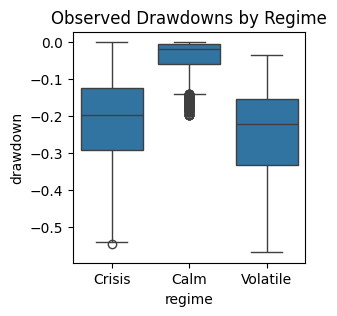

In [ ]:
# actual market drawdowns differ across regimes

plt.figure(figsize=(3,3))
sns.boxplot(x='regime', y='drawdown', data=df)
plt.title("Observed Drawdowns by Regime")
plt.show()


| Regime       | Observed Behavior                            | Interpretation                                                   |
| ------------ | -------------------------------------------- | ---------------------------------------------------------------- |
| **Calm**     | Small, tightly clustered drawdowns near zero | Markets are stable; losses are shallow and quickly recovered     |
| **Volatile** | Wider spread, deeper median drawdowns        | Turbulent conditions with larger swings and higher downside risk |
| **Crisis**   | Deepest and most dispersed drawdowns         | Severe, persistent market stress with extreme downside events    |


- **Crisis regimes** show the deepest and most extreme drawdowns, confirming structural stress.

- **Calm regimes** cluster near zero drawdown with limited downside.

- **Volatile regimes** exhibit wide dispersion, indicating turbulence without sustained collapse.

This validates the idea that the same volatility level has different risk meaning depending on regime.

# **Model Comparision**

In [ ]:
x_no_regime = df[
    ['volatility', 'trend_strength', 'momentum']
]

x_train_nr, x_test_nr, y_train, y_test = train_test_split(
    x_no_regime, y,
    test_size=0.25,
    shuffle=False
)

scaler_nr = StandardScaler()
x_train_nr = scaler_nr.fit_transform(x_train_nr)
x_test_nr = scaler_nr.transform(x_test_nr)

model_nr = LogisticRegression(max_iter=1000)
model_nr.fit(x_train_nr, y_train)

roc_nr = roc_auc_score(y_test, model_nr.predict_proba(x_test_nr)[:, 1])


In [ ]:
print("With regime:", roc_auc_score(y_test, y_prob))
print("Without regime:", roc_nr)

With regime: 0.8431128707510617
Without regime: 0.8254459728496579


> the model does not rely on regime to work, but it works better when regime context is included.

# **Save Output**

In [ ]:
import os
os.makedirs("outputs", exist_ok=True)

test_df[['risk_probability', 'drawdown_risk', 'regime']].to_csv(
    "outputs/drawdown_risk.csv"
)

test_df[['risk_probability', 'drawdown_risk', 'regime']].to_json(
    "outputs/drawdown_risk.json"
)



# **Conclusion**

In this notebook, we extended regime discovery into a **regime-aware drawdown risk prediction framework**.

- market returns
- volatility
- momentum
- trend strength, and
- explicit regime labels,

we modeled the **probability that the market enters a high drawdown risk state the next day**.

The results show that drawdown risk is **not only driven by volatility, but is strongly conditioned by the prevailing market regime**.




- Drawdown risk is **state-persistent**, clustering over time rather than reverting daily

- The **same volatility implies different risk** across regimes

- Crisis and Volatile regimes **structurally amplify downside risk**

- Regime context improves **risk discrimination** (ROC-AUC ↑ vs no-regime model)

Drawdowns are **regime-dependent risk states**, not isolated return shocks.
This framework shifts focus from return prediction to **early stress detection**, enabling more interpretable and robust risk control within MSIS.

# **Sample Prediction**

In [ ]:
sample = pd.DataFrame({
    "volatility": [0.015],
    "trend_strength": [-0.002],
    "momentum": [-0.01],
    "regime": ["Volatile"]
})

risk_prob = model.predict_proba(sample)[0, 1]
print(f"Predicted next-day drawdown risk: {risk_prob:.2%}")


Predicted next-day drawdown risk: 98.59%


In [ ]:
scenarios = pd.DataFrame({
    "volatility": [0.005, 0.012, 0.020],
    "trend_strength": [0.001, -0.001, -0.004],
    "momentum": [0.008, -0.004, -0.02],
    "regime": ["Calm", "Volatile", "Crisis"]
})

scenarios["risk_prob"] = model.predict_proba(scenarios)[:,1]
scenarios


,volatility,trend_strength,momentum,regime,risk_prob
0,0.005,0.001,0.008,Calm,0.092355
1,0.012,-0.001,-0.004,Volatile,0.948510
2,0.020,-0.004,-0.020,Crisis,0.997648
